# Final Task: Credit Risk Predicition Model
# Project Based Internship ID/X Partners x Rakamin Academy

## 1. Import Libraries

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import xgboost as xgb
from scipy.stats import chi2_contingency, f_oneway 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")

## 2. Load Data & Data Understanding

In [88]:
# load the dataset
df = pd.read_csv("../Data/loan_data_2007_2014.csv", low_memory=False)

# split data by categorical and numeric
categoric = df.select_dtypes("object")
numeric = df.select_dtypes("number")

# split data by rows and columns
rows = df.shape[0]
cols = df.shape[1]

In [89]:
# display data shape
print("Data shape:")
print(f"Number of rows: {rows} \nNumber of columns: {cols}")

Data shape:
Number of rows: 466285 
Number of columns: 75


In [90]:
# display data overview
print("Data overview:")
display(df.sample(3))

Data overview:


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
451683,451683,11235357,13147524,6500,6500,6500.0,36 months,11.99,215.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,16500.0,NaN,NaN,NaN
140744,140744,4297327,5469707,4750,4750,4750.0,36 months,12.12,158.05,B,...,NaN,NaN,NaN,NaN,NaN,NaN,26600.0,NaN,NaN,NaN
174711,174711,3005747,3637985,10000,10000,10000.0,36 months,18.75,365.30,D,...,NaN,NaN,NaN,NaN,NaN,NaN,12500.0,NaN,NaN,NaN


In [91]:
# display categorical data summary
print("Categorical data summary:")
display(categoric.describe())

Categorical data summary:


,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,...,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
count,466285,466285,466285,438697,445277,466285,466285,466285,466285,466285,...,466285,466264,466285,466285,466256,466285,465909,239071,466243,466285
unique,2,7,35,205475,11,6,3,91,9,2,...,14,63098,888,50,664,2,98,100,103,1
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Verified,Oct-14,Current,n,...,debt_consolidation,Debt consolidation,945xx,CA,Oct-00,f,Jan-16,Feb-16,Jan-16,INDIVIDUAL
freq,337953,136929,31686,5399,150049,235875,168055,38782,224226,466276,...,274195,164075,5304,71450,3674,303005,179620,208393,327699,466285


In [92]:
# display numerical data summary
print("Numerical data summary:")
display(numeric.describe())

Numerical data summary:


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,466285.000000,4.662850e+05,4.662850e+05,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,4.662810e+05,466285.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.960090e+05,0.0,0.0,0.0
mean,233142.000000,1.307973e+07,1.459766e+07,14317.277577,14291.801044,14222.329888,13.829236,432.061201,7.327738e+04,17.218758,...,NaN,NaN,NaN,NaN,NaN,NaN,3.037909e+04,NaN,NaN,NaN
std,134605.029472,1.089371e+07,1.168237e+07,8286.509164,8274.371300,8297.637788,4.357587,243.485550,5.496357e+04,7.851121,...,NaN,NaN,NaN,NaN,NaN,NaN,3.724713e+04,NaN,NaN,NaN
min,0.000000,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
25%,116571.000000,3.639987e+06,4.379705e+06,8000.000000,8000.000000,8000.000000,10.990000,256.690000,4.500000e+04,11.360000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.350000e+04,NaN,NaN,NaN
50%,233142.000000,1.010790e+07,1.194108e+07,12000.000000,12000.000000,12000.000000,13.660000,379.890000,6.300000e+04,16.870000,...,NaN,NaN,NaN,NaN,NaN,NaN,2.280000e+04,NaN,NaN,NaN
75%,349713.000000,2.073121e+07,2.300154e+07,20000.000000,20000.000000,19950.000000,16.490000,566.580000,8.896000e+04,22.780000,...,NaN,NaN,NaN,NaN,NaN,NaN,3.790000e+04,NaN,NaN,NaN
max,466284.000000,3.809811e+07,4.086083e+07,35000.000000,35000.000000,35000.000000,26.060000,1409.990000,7.500000e+06,39.990000,...,NaN,NaN,NaN,NaN,NaN,NaN,9.999999e+06,NaN,NaN,NaN


In [93]:
# Review all categorical data values
for col in categoric.columns:
    print(categoric[col].value_counts())
    print("-"*35,"*"*3)

term
36 months    337953
60 months    128332
Name: count, dtype: int64
----------------------------------- ***
grade
B    136929
C    125293
D     76888
A     74867
E     35757
F     13229
G      3322
Name: count, dtype: int64
----------------------------------- ***
sub_grade
B3    31686
B4    30505
C1    26953
C2    26740
B2    26610
C3    25317
B5    25252
C4    24105
B1    22876
C5    22178
A5    21757
D1    19261
A4    19045
D2    17046
D3    14916
D4    14099
A3    12568
D5    11566
A2    10956
A1    10541
E1     9033
E2     8669
E3     6976
E4     5992
E5     5087
F1     3940
F2     3001
F3     2708
F4     2067
F5     1513
G1     1109
G2      823
G3      583
G4      422
G5      385
Name: count, dtype: int64
----------------------------------- ***
emp_title
Teacher                              5399
Manager                              4438
Registered Nurse                     2316
RN                                   2204
Supervisor                           1967
                 

In [94]:
# Review all numerical data values
for col in numeric.columns:
    print(numeric[col].value_counts())
    print("-"*35,"*"*3)

Unnamed: 0
0         1
310839    1
310865    1
310864    1
310863    1
         ..
155424    1
155423    1
155422    1
155421    1
466284    1
Name: count, Length: 466285, dtype: int64
----------------------------------- ***
id
1077501     1
26180404    1
26219322    1
26239577    1
26290537    1
           ..
3714715     1
3703738     1
3731030     1
3705772     1
9199665     1
Name: count, Length: 466285, dtype: int64
----------------------------------- ***
member_id
1296599     1
28653081    1
28692177    1
28702376    1
28763241    1
           ..
4686866     1
4847180     1
4724047     1
4678105     1
11061576    1
Name: count, Length: 466285, dtype: int64
----------------------------------- ***
loan_amnt
10000    33023
12000    25519
15000    23486
20000    22759
35000    16596
         ...  
34250        1
33400        1
32150        1
34325        1
33175        1
Name: count, Length: 1352, dtype: int64
----------------------------------- ***
funded_amnt
10000    32930
12000   

## 3. Exploratory Data Analysis (EDA)

### Missing values checking

In [243]:
# define a missing values checking function
def check_missing(data, op, pct):
    # sort for missing values columns percentage
    sorted_missing_pct = sorted(data, key=lambda x: (data[x].isnull().sum() / len(data)), reverse=True)
    
    # variable to count the number of missing values
    cnt_missing_cols = 0
    cnt_missing_cols_pct = 0

    # define columns that have missing values
    data_name = [name for name, value in globals().items() if value is data][0]
    print(f"{data_name} columns with missing values:")

    # iterate columns with missing values
    for col in sorted_missing_pct:
        missing_pct = (data[col].isnull().sum() / len(data)) * 100

        if op == ">" and missing_pct > 0:
            num_missing_pct = missing_pct > pct
            print(f"{col} ({missing_pct:.2f}%)")
            cnt_missing_cols += 1
            if num_missing_pct:
                cnt_missing_cols_pct += 1

        elif op == "<" and missing_pct > 0:
            num_missing_pct = missing_pct < pct
            print(f"{col} ({missing_pct:.2f}%)")
            cnt_missing_cols += 1
            if num_missing_pct:
                cnt_missing_cols_pct += 1

        elif op == "=" and missing_pct > 0:
            num_missing_pct = missing_pct == pct
            print(f"{col} ({missing_pct:.2f}%)")
            cnt_missing_cols += 1
            if num_missing_pct:
                cnt_missing_cols_pct += 1

        elif op == "!=" and missing_pct > 0:
            num_missing_pct = missing_pct != pct
            print(f"{col} ({missing_pct:.2f}%)")
            cnt_missing_cols += 1
            if num_missing_pct:
                cnt_missing_cols_pct += 1

    print(f"\nTotal columns with missing values is {cnt_missing_cols} columns")
    print(f"Total columns with {op}{pct}% missing values is {cnt_missing_cols_pct} columns")

In [244]:
# run the function
check_missing(df, ">", 40)
print("-"*55)
check_missing(categoric, ">", 40)
print("-"*55)
check_missing(numeric, ">", 40)

df columns with missing values:
annual_inc_joint (100.00%)
dti_joint (100.00%)
verification_status_joint (100.00%)
open_acc_6m (100.00%)
open_il_6m (100.00%)
open_il_12m (100.00%)
open_il_24m (100.00%)
mths_since_rcnt_il (100.00%)
total_bal_il (100.00%)
il_util (100.00%)
open_rv_12m (100.00%)
open_rv_24m (100.00%)
max_bal_bc (100.00%)
all_util (100.00%)
inq_fi (100.00%)
total_cu_tl (100.00%)
inq_last_12m (100.00%)
mths_since_last_record (86.57%)
mths_since_last_major_derog (78.77%)
desc (72.98%)
mths_since_last_delinq (53.69%)
next_pymnt_d (48.73%)
tot_coll_amt (15.07%)
tot_cur_bal (15.07%)
total_rev_hi_lim (15.07%)
emp_title (5.92%)
emp_length (4.51%)
last_pymnt_d (0.08%)
revol_util (0.07%)
collections_12_mths_ex_med (0.03%)
last_credit_pull_d (0.01%)
delinq_2yrs (0.01%)
earliest_cr_line (0.01%)
inq_last_6mths (0.01%)
open_acc (0.01%)
pub_rec (0.01%)
total_acc (0.01%)
acc_now_delinq (0.01%)
title (0.00%)
annual_inc (0.00%)

Total columns with missing values is 40 columns
Total columns

Number of missing value:
- There are many missing values in the dataframe column. 40 columns contain missing values and 22 columns contain more than 40% missing values.
- In the categorical column. 8 columns contain missing values and 2 columns contain more than 40% missing values.
- In the numerical column. 32 columns contain missing values and 20 columns contain more than 40% missing values.

Action:
- For columns with missing values more than 40%, I will drop them later
- For the rest of the columns that still contain missing values I decided to impute them later

### Duplicate values checking

In [241]:
# define a duplicate values checking function
def check_duplicate(data):
    cnt_duplicate = data.duplicated().sum()
    data_name = [name for name, value in globals().items() if value is data][0]
    print(f"Total duplicate values in {data_name} columns: \n{cnt_duplicate}")

# run the function
check_duplicate(df)

Total duplicate values in df columns: 
0


This dataset doesn't contain any duplicate values.

### Outlier checking

In [275]:
# create a copy of dataframe
numeric_copy = numeric.copy()

# define a missing percentage function to list a columns with missing values
def missing_pct(data, pct):
    miss_cols = []

    for col in data:
        missing_val = (data[col].isnull().sum() / len(data)) * 100
        if missing_val > pct:
            miss_cols.append(col)
    return miss_cols

# create a variable: numeric columns without missing values
numeric_without_miss = numeric_copy.drop(columns=missing_pct(numeric, 40))

# print columns with missing values more than 40%
print(numeric_without_miss.columns)

Index(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')


#### With Boxplot

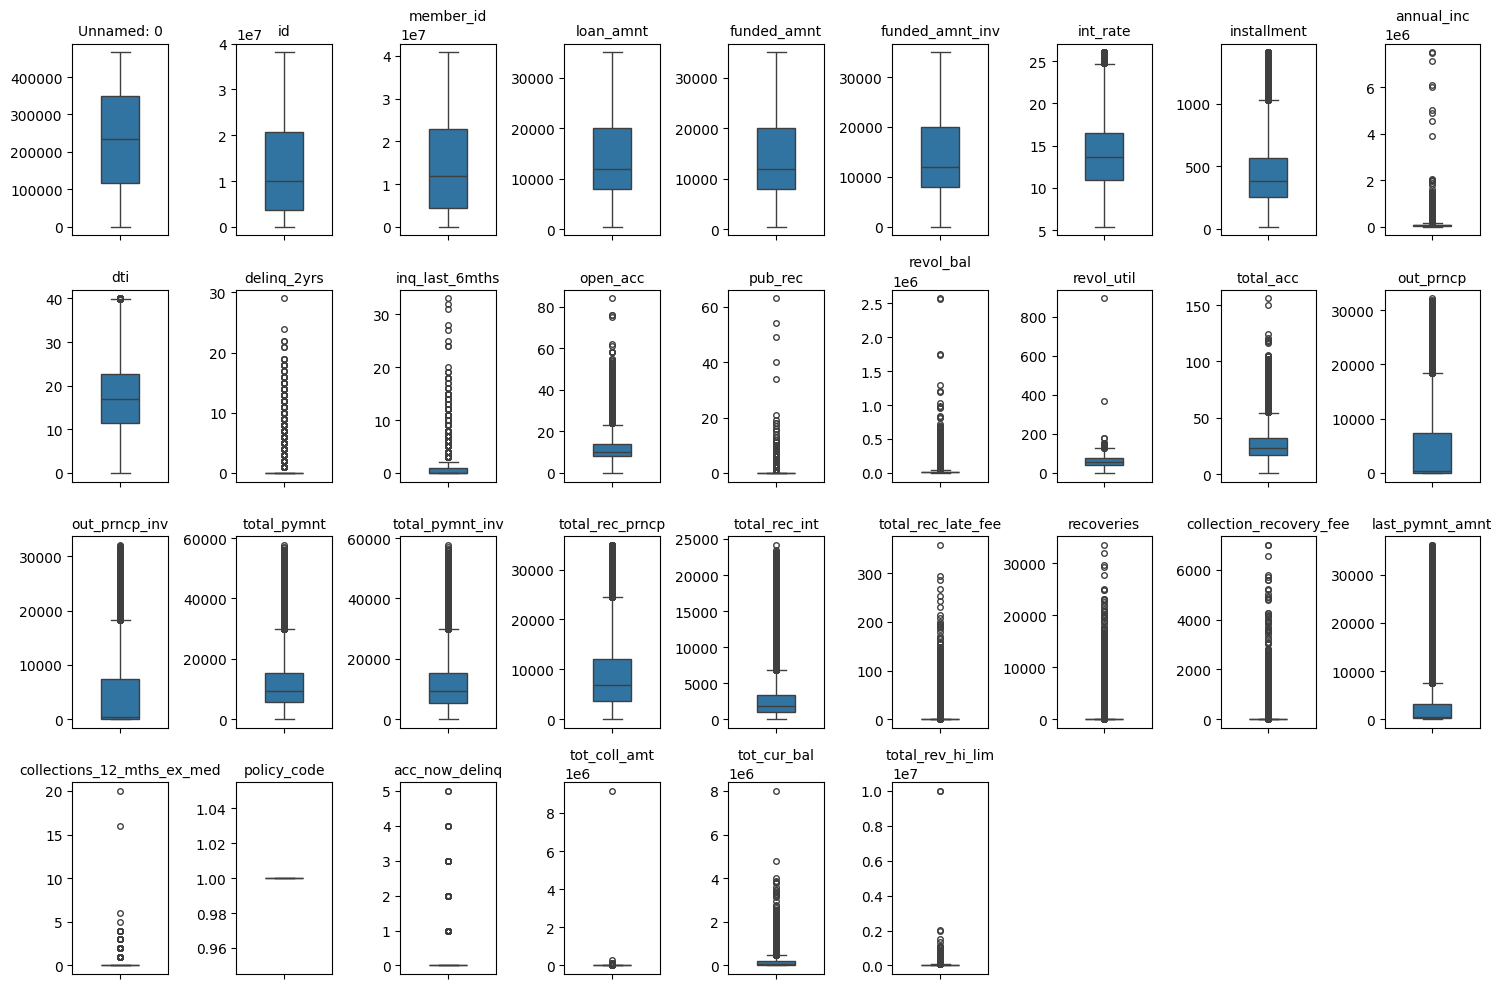

In [246]:
# loop boxplot for each columns in numeric_without_miss dataframe
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_without_miss.columns):
    plt.subplot(4, 9, i+1)
    sns.boxplot(numeric[col], width=0.4, fliersize=4)
    plt.ylabel(None)
    plt.title(col, fontsize=10)
    plt.tight_layout()

plt.show()

#### With KDE plot

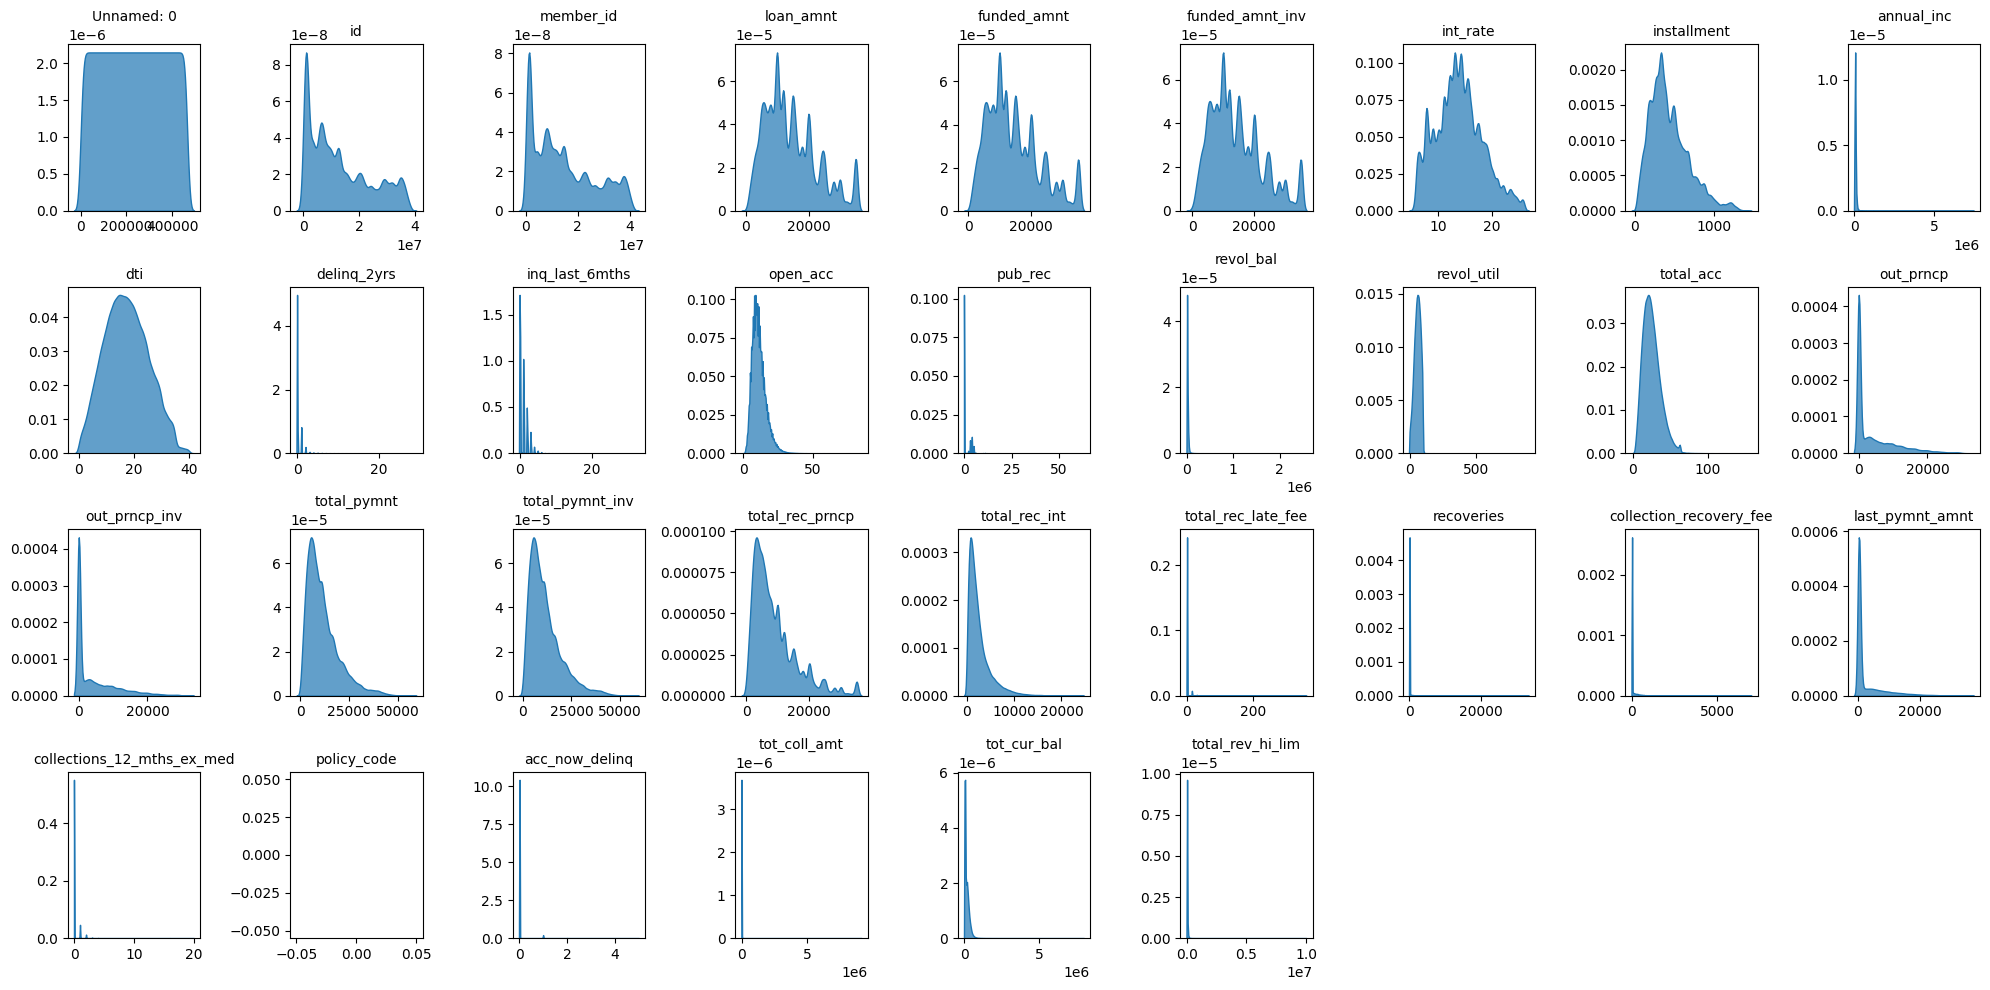

In [282]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(numeric_without_miss.columns):
    plt.subplot(4, 9, i+1)
    sns.kdeplot(numeric[col], fill=True, alpha=0.7)
    plt.title(col, fontsize=10)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.tight_layout()

# Display the plot 
plt.show()

#### With Z-Score

In [276]:
# define a z-score function
def check_outliers_zscore(data, cols_name="None"):
    outliers = []
    cols_name = data.columns

    for i, col in enumerate(data.columns):
        mean = np.mean(data[col])
        std = np.std(data[col])

        threshold = 3
        
        z_scores = [(x - mean)/std for x in data[col]]
        col_outliers = [i for i, z in enumerate(z_scores) if abs(z) > threshold]

        if len(col_outliers) > 0:
            outliers.append(cols_name[i])

    return outliers

In [281]:
# run check_outliers_zscore function
print(f'Total columns with outliers: {len(check_outliers_zscore(numeric_without_miss))} columns')
check_outliers_zscore(numeric_without_miss)

Total columns with outliers: 24 columns


['installment',
 'annual_inc',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim']

### Imbalanced

halo selamat pagii !!!